In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from runs.train.transformer_v2.2024_07_05_09:51:03.07.codes.transformer_v2

# Count parameterts in model

In [2]:
# Function to count the number of parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


In [4]:
class DotDict(dict):
    """A dictionary with dot notation access to attributes."""
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(f"'DotDict' object has no attribute '{key}'")

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        try:
            del self[key]
        except KeyError:
            raise AttributeError(f"'DotDict' object has no attribute '{key}'")
        
# Function to convert existing dictionary to DotDict
def dict_to_dotdict(d):
    if not isinstance(d, dict):
        return d
    return DotDict({k: dict_to_dotdict(v) if isinstance(v, dict) else v for k, v in d.items()})



In [6]:
from models.transformer_bilstm_v2 import TransformerBiLSTM
from models.transformer_v1 import Transformer
opt = {
    'block_size': 15552,
    'block_stride': 972,
    'patch_size': 18,
    'max_grad_norm': 1.0,
    'fog_model_input_dim': 54,
    'fog_model_dim': 320,
    'fog_model_num_heads': 8,
    'fog_model_num_encoder_layers': 5,
    'fog_model_num_lstm_layers': 2,
    'fog_model_first_dropout': 0.1,
    'fog_model_encoder_dropout': 0.1,
    'fog_model_mha_dropout': 0.0,
}

opt = DotDict(opt)

model = TransformerBiLSTM(opt)
transformer_model = Transformer(opt)

# Get the total and trainable parameters
total_params, trainable_params = count_parameters(model)

print(f"TransformerBiLSTM Total parameters: {total_params}")
print(f"TransformerBiLSTM Trainable parameters: {trainable_params}")

total_params, trainable_params = count_parameters(transformer_model)

print(f"Transformer Total parameters: {total_params}")
print(f"Transformer Trainable parameters: {trainable_params}")

TransformerBiLSTM Total parameters: 7486402
TransformerBiLSTM Trainable parameters: 7486402
Transformer Total parameters: 3379522
Transformer Trainable parameters: 3379522


# Process Data

In [24]:
import joblib, random, torch

random.seed(11)
pickle_path = "data/rectified_data/dataset_fog_release/val_dataset_fog_release.p"

all_data = joblib.load(pickle_path)

print(len(all_data.keys()))
print(all_data[200].keys())

gt = all_data[200]['gt']
print(all_data[200]['series_name'])
print(gt.shape)
print(gt[-3:])

285
dict_keys(['series_name', 'start_t_idx', 'end_t_idx', 'model_input', 'gt'])
rectified_16_dataset_fog_release
torch.Size([15552])
tensor([2, 2, 2], dtype=torch.int8)


In [4]:

import torch
bce = torch.nn.BCELoss(reduction='none')

pred = torch.rand(2,6)
mask = torch.tensor([[0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0, 1]]).float()

loss = bce(pred, mask)
loss.shape, loss


(torch.Size([2, 6]),
 tensor([[1.7707, 2.4249, 0.1701, 0.8715, 2.5939, 1.6950],
         [1.1421, 0.6567, 0.1020, 0.8278, 0.0357, 1.0962]]))

# Overfit training example

In [38]:
class DictToObj:
    def __init__(self, dictionary):
        self.__dict__.update(dictionary)
    
    def __getattr__(self, name):
        return self.__dict__.get(name)
    
opt = {
    'seed': 11,
    'optimizer': 'adamw',
    'learning_rate': 0.00026,
    'adam_betas': (0.9, 0.98),
    'adam_eps': 1.0e-09,
    'weight_decay': 0,
    'lr_scheduler_factor': 0.1,
    'lr_scheduler_patience': 20,
    'lr_scheduler_warmup_steps': 64,
    'train_num_steps': 20000,
    'penalty_cost': 2.0,
    'block_size': 15552,
    'block_stride': 972,
    'patch_size': 18,
    'fog_model_input_dim': 162,
    'fog_model_dim': 320,
    'fog_model_num_heads': 8,
    'fog_model_num_encoder_layers': 5,
    'fog_model_num_lstm_layers': 2,
    'fog_model_first_dropout': 0.1,
    'fog_model_encoder_dropout': 0.1,
    'fog_model_mha_dropout': 0.0,
}
opt = DictToObj(opt)

import torch
import numpy as np
import random
from models.transformer_bilstm_v1 import TransformerBiLSTM

random.seed(opt.seed)
np.random.seed(opt.seed)
torch.manual_seed(opt.seed)

model = TransformerBiLSTM(opt)


#### Train

In [18]:

from data.fog_dataset_v1 import FoGDataset

train_dpath = "data/rectified_data/dataset_fog_release/train1_dataset_fog_release_blks15552_ps18.p"
model_path = "runs/train/transfomer_bilstm/2024_06_12_21:12:41.10/weights/model_regular_19991.pt"

model.load_state_dict(torch.load(model_path)['model'])


<All keys matched successfully>

In [19]:
import joblib
train_ds = joblib.load(train_dpath)
len(train_ds.keys()), train_ds[1].keys(), train_ds[1]['model_input'].shape, train_ds[1]['gt'].shape

(1055,
 dict_keys(['series_name', 'start_t_idx', 'end_t_idx', 'model_input', 'gt']),
 torch.Size([864, 162]),
 torch.Size([864, 3]))

In [20]:
model_input = []
gt = []
for i in range(32):
    model_input.append(train_ds[i]['model_input'][None, :, :])
    gt.append(train_ds[i]['gt'][None, :, :])

model_input= torch.cat(model_input, dim=0)
gt = torch.cat(gt, dim=0)
model_input.shape, gt.shape

(torch.Size([32, 864, 162]), torch.Size([32, 864, 3]))

#### Validation

In [39]:
from data.fog_dataset_v1 import FoGDataset

val_dpath = "data/rectified_data/dataset_fog_release/val1_dataset_fog_release_blks15552_ps18.p"
model_path = "runs/train/transfomer_bilstm/2024_06_12_21:12:41.10/weights/model_regular_19991.pt"


model.load_state_dict(torch.load(model_path)['model'])
import joblib
val_ds = joblib.load(val_dpath)

model_input = []
gt = []
for i in range(32):
    model_input.append(val_ds[i]['model_input'][None, :, :])
    gt.append(val_ds[i]['gt'][None, :, :])

model_input= torch.cat(model_input, dim=0)
gt = torch.cat(gt, dim=0)

model_input.shape, gt.shape

(torch.Size([32, 864, 162]), torch.Size([32, 864, 3]))

In [40]:
pred = model(model_input)
loss = loss_func(pred, gt)
precision, recall, f1, ap = evaluation_metrics(pred, gt)
precision, recall, f1, ap, loss

(tensor(0.7070),
 tensor(0.5953),
 tensor(0.6464),
 tensor(0.4415),
 tensor(4.1332, grad_fn=<DivBackward0>))

#### Check test data doesn't overlap with train and valid

In [4]:
import joblib, torch
train_dpath = "data/rectified_data/kaggle_pd_data/train_kaggle_pd_data_window2976_lab_randomaug.p"
train_data = joblib.load(train_dpath)
val_dpath = "data/rectified_data/kaggle_pd_data/val_kaggle_pd_data_window2976_lab_randomaug.p"
val_data = joblib.load(val_dpath)
test_dpath = "data/rectified_data/kaggle_pd_data/test_kaggle_pd_data_window2976_lab_randomaug.p"
test_data = joblib.load(test_dpath)
len(train_data.keys()),len(val_data.keys()),len(test_data.keys()), train_data[0].keys()

(2611,
 86,
 87,
 dict_keys(['series_name', 'ori_series_name', 'start_t_idx', 'end_t_idx', 'model_input', 'gt', 'inference_gt']))

In [5]:
train_set, val_set, test_set = set(), set(), set()
for key, value in train_data.items():
    train_set.add(value['ori_series_name'])
for key, value in val_data.items():
    val_set.add(value['ori_series_name'])
for key, value in test_data.items():
    test_set.add(value['ori_series_name'])

In [6]:
overlap = train_set & val_set & test_set
overlap, len(train_set), len(val_set), len(test_set)

(set(), 776, 29, 28)

In [54]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('data/rectified_data/kaggle_pd_data/tdcsfog/gt_kaggle_pd_data.csv')

# Extract the 733rd column (index 732)
print(df.iloc[:2, 0])
column_733 = df.iloc[:6973, 732]  # 6973 because Python's slicing is exclusive on the upper bound

# Check if there is any '1' in the extracted column
if (column_733 == 1).any():
    print("There is at least one '1' in the 733rd column from index 0 to 6972.")
else:
    print("There are no '1's in the 733rd column from index 0 to 6972.")

0    0.0
1    0.0
Name: GroundTruth_Trial1, dtype: float64
There are no '1's in the 733rd column from index 0 to 6972.


In [1]:
import torch

a= torch.randint(0,9, size=(4,3)).to("cuda:3")
a, a.permute(1,0)

(tensor([[4, 2, 6],
         [8, 3, 1],
         [3, 7, 4],
         [8, 1, 5]], device='cuda:3'),
 tensor([[4, 8, 3, 8],
         [2, 3, 7, 1],
         [6, 1, 4, 5]], device='cuda:3'))

In [1]:
import joblib, torch

all_dpath = "data/rectified_data/kaggle_pd_data/all_kaggle_pd_data.p"
all_data = joblib.load(all_dpath)
len(all_data.keys())

970

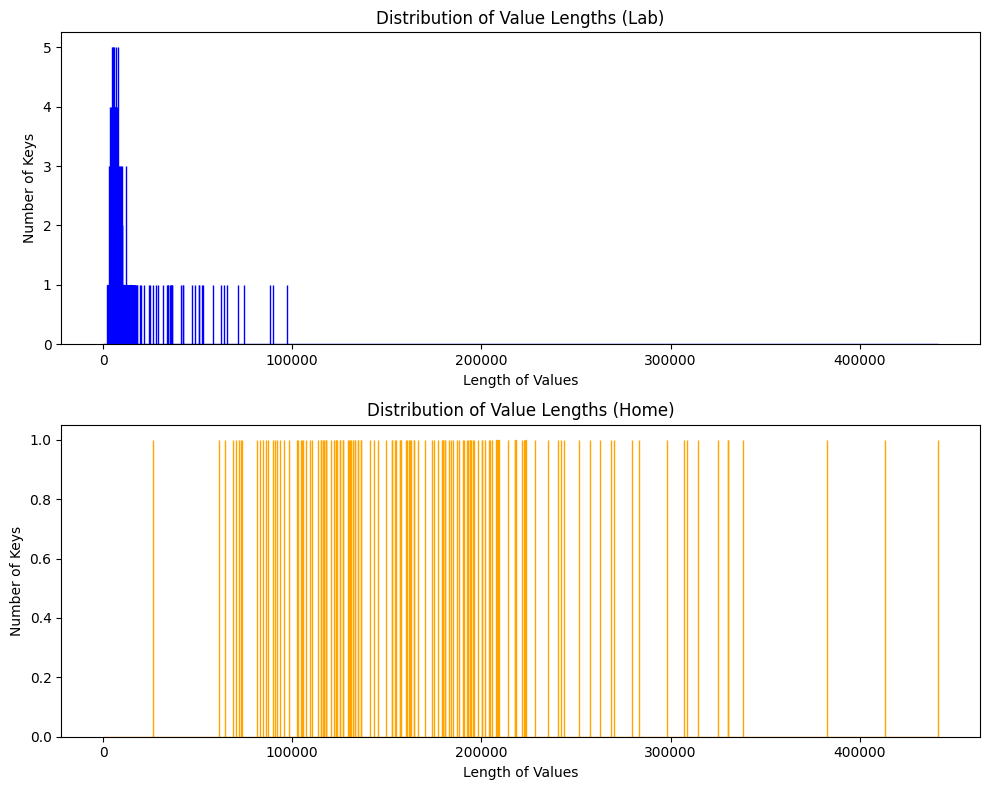

lab: 833 min: 2359 max: 97077
home:  137 min: 26342 max: 441496


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Extract the lengths of the values in the dictionary

home = []
lab = []
for key, value in all_data.items():
    if value['ori_filename'].split('_')[-1] == 'tdcsfog':
        lab.append(int(value['gt'].shape[0]))
    else:
        home.append(int(value['gt'].shape[0]))
# Step 2: Define bin edges (adjust the range and step as needed)
bin_edges = np.arange(0, max(max(lab, default=0), max(home, default=0)) + 10, 10)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Histogram for lab data
ax1.hist(lab, bins=bin_edges, edgecolor='blue')
ax1.set_xlabel('Length of Values')
ax1.set_ylabel('Number of Keys')
ax1.set_title('Distribution of Value Lengths (Lab)')

# Histogram for home data
ax2.hist(home, bins=bin_edges, edgecolor='orange')
ax2.set_xlabel('Length of Values')
ax2.set_ylabel('Number of Keys')
ax2.set_title('Distribution of Value Lengths (Home)')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
print("lab:", len(lab), "min:", min(lab), "max:", max(lab))
print("home: ",len(home), "min:", min(home), "max:", max(home))



In [3]:
import statistics
print("lab median: ", statistics.median(lab))
print("home median: ", statistics.median(home))

lab median:  6290
home median:  161720


In [4]:
# Function to calculate the ratio
def calculate_class_ratio(train_data):
    ones = 0
    zeros = 0
    twos = 0
    for example_id, example_data in train_data.items():
        gt = example_data['gt']
        num_zeros = torch.sum(gt[:,0] == 1).item()
        num_ones = torch.sum(gt[:,1] == 1).item()
        num_twos = torch.sum(gt[:,2] == 1).item()
        ones += num_ones
        zeros += num_zeros
        twos += num_twos
    print("one: ", ones)
    print("zero: ", zeros)
    print("two: ", twos)
    print("zero to one: ", zeros / ones)
    print()
    return zeros, ones, twos

zeros, ones, twos = 0, 0, 0
# Calculate the ratio for the training data
print('train')
a,b,c=calculate_class_ratio(train_data)
zeros += a
ones += b
twos += c

print('val:')
a,b,c=calculate_class_ratio(val_data)
zeros += a
ones += b
twos += c

print('test')
a,b,c=calculate_class_ratio(test_data)
zeros += a
ones += b
twos += c

print("all zeros: ", zeros)
print("all ones: ", ones)
print("all twos: ", twos)



train
one:  2093693
zero:  4541566
two:  1135077
zero to one:  2.169165202348195

val:
one:  20544
zero:  184261
two:  51131
zero to one:  8.969090732087228

test
one:  77173
zero:  145435
two:  36304
zero to one:  1.884532155028313

all zeros:  4871262
all ones:  2191410
all twos:  1222512


In [55]:
import pandas as pd
import os

# Path to the folder containing CSV files
folder_path = 'data/kaggle_pd_data/train/tdcsfog'

# Initialize counters for zero and one
zero_count = 0
one_count = 0

# Iterate over each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Read the CSV file
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        
        # Check if the specific columns exist
        if all(col in df.columns for col in ["StartHesitation", "Turn", "Walking"]):
            # Create the new column
            df['NewColumn'] = df[["StartHesitation", "Turn", "Walking"]].any(axis=1).astype(int)
            
            # Update counters
            zero_count += (df['NewColumn'] == 0).sum()
            one_count += (df['NewColumn'] == 1).sum()

# Calculate the ratio of zero to one
if one_count == 0:
    ratio = float('inf')  # To handle division by zero
else:
    ratio = zero_count / one_count

print(f"Ratio of zeros to ones in the new column across all files: {ratio:.2f}")
print(f"Zero count: {zero_count}, One count: {one_count}")


Ratio of zeros to ones in the new column across all files: 2.22
Zero count: 4871262, One count: 2191410
